Statistics (I)(2) Final Project
===

<font face="微軟正黑體">
<b>組長</b> : 劉鎮霆 B07705015 <br>
<b>組員</b> : 黃煒勛 B07705010 | 黃　心 B07705013 | 康　崴 B07705014 | 張宇承 B07705017 | 李旻叡 B07705037
</font>

## <center>Table of Contents</center>

---

[<center><font face="微軟正黑體">分析主題</font></center>](#分析主題)
[<center><font face="微軟正黑體">動機</font></center>](#動機)
[<center><font face="微軟正黑體">敘述統計 & 視覺化</font></center>](#分析主題)
[<center><font face="微軟正黑體">假設檢定</font></center>](#動機)
[<center><font face="微軟正黑體">迴歸分析</font></center>](#分析主題)
[<center><font face="微軟正黑體">結論與建議</font></center>](#動機)

---


**<font face="微軟正黑體">分析主題</font>**
---

<font face="微軟正黑體">Spotify 串流平台中歌曲特性對熱門程度的影響</font>

**<font face="微軟正黑體">前言</font>**
---

<font face="微軟正黑體">
&emsp;&emsp;現今社會串流音樂蔚為主流，全世界有數億人在使用這類的服務。而在眾多的串流服務中又以 Spotify 為箇中翹楚，它有著 2.86 億個使用者，想必各個音樂發行商的競爭也是十分激烈。我們這些平時熱愛音樂的學生不禁好奇，一首歌要有怎麼樣的特性才可以在 Spotify 的使用環境中脫穎而出，得到較高的熱門程度。若是知道熱門程度與歌曲各項特性的關係，或許發行商可以根據此關係調整策略，獲得較高的觸及率和收益。我們先由敘述統計觀察不同曲風熱門程度分佈，接著做回歸分析發現曲風影響熱門程度，最後由假設檢定看曲風的差異性是怎麼決定熱門程度以及曲風之間哪些特性有差異。
</font>

**<font face="微軟正黑體">資料集</font>**
---

### 1. **<font face="微軟正黑體">資料蒐集</font>**

<font face="微軟正黑體">
    &emsp;&emsp;我們首先在 kaggle 上找到
    <a href='https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db'>Spotify 歌曲資料集</a>,
    其中包含了每一首歌的曲風、歌手、流行度 (popularity)、原聲性 (acousticness) 等數據。
    由於 kaggle 上的資料比較舊 (2019年3月)，再加上其中的曲風有經過人為處理 (例如將 kids 與 children 合併為一種曲風)，因此我們決定參考它蒐集資料的方法，重新蒐集歌曲資料。<br>
    &emsp;&emsp;抽樣時，我們採用 stratified sampling，透過 Soptipy 函式庫搜尋 Spotify 上各個曲風的歌曲 (會回傳歌曲資料的list)，再各自隨機抽樣出 100 首歌，程式碼如下：<br>
    (由於不同時間的搜尋結果會不一樣，因此即使設定相同的 random seeds 也無法 reproduce)
</font>

### 2. **<font face="微軟正黑體">欄位介紹</font>**

- name: 歌曲名稱<br>
- available_market: 歌曲在多少地區可以被取得<br>
- explicit: 是否有明確的歌詞 (由提供者標示)<br>
- genre: 歌曲種類，共 112 種 (每種各 100 首歌)<br>
- popularity: 流行程度，數值範圍為 0到100。評分標準主要基於播放總數及近期播放數。一般來說，最近常播放的歌曲比過去常播放的歌曲有更高的流行度。<br>
- acousticness: 原聲性，數值範圍為 0到1。1 代表有很高的信心認定這首歌是不經過電子音效處理，可以聽到最直接的樂音及人聲。<br>
- danceability: 舞蹈性，數值範圍為 0到1。根據拍子、節奏和整體規律來決定是否適合跳舞。<br>
- duration_ms: 歌曲長度，以毫秒為單位。<br>
- energy: 能量，數值範圍為 0到1。代表感受上的強度與活力。一般來說，從有能量的歌曲會感受到快、大聲與嘈雜，而評分的特徵包含dynamic range、 perceived loudness, timbre, onset rate, 和general entropy。<br>
- instrumentalness: 樂器性，數值範圍為 0到1。偵測歌曲是否沒有人聲 (哼唱算樂器，而說唱或言語則為人聲)，此數值 >0.5 即可代表純樂器，不過越接近 1 信心水準越高。<br>
- key: 調，代表不同 standard Pitch Class notation，如 0=C, 1=C♯/D♭, 2=D，若無則為-1。<br>
- liveness: 數值範圍為 0到1。越高代表現場演奏的可能性高，>0.8表示極有可能為現場演奏。<br>
- loudness: 歌曲整體的響度，單位為分貝 (dB)，數值為整首歌的平均值，大部分在 -60至0。<br>
- mode: 調式，大調為1，小調為0。<br>
- speechiness: 言語性，數值範圍為 0到1。越接近純粹的言語 (如:脫口秀、有聲書、誦詩)，此數值越接近 1，>0.66 代表很有可能皆為言語所構成，0.33到0.66 則可能有部分為言語(如:說唱)，<0.33 為音樂或其他非言語性歌曲。<br>
- tempo: 節奏，單位為 beats per minute (BPM)。<br>
- time_signature: 歌曲整體的拍子。<br>
- valence: 正向性，數值範圍為 0到1，較高代表此音樂聽起來較為正面，較低則為負面。

**<font face="微軟正黑體">敘述統計 & 視覺化</font>**
---

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso
pd.options.display.max_rows = 999

df = pd.read_csv("tracks_no_may.csv")

### 2. **<font face="微軟正黑體">歌曲類型選擇與熱門度觀察</font>**

In [6]:
cato = [ 'j-pop', 'k-pop', 'hip-hop','country', 'dance', 'jazz', 'pop', 'blues']

我們選擇了'j-pop', 'k-pop', 'hip-hop','country', 'dance', 'jazz', 'pop', 'blues'共8種歌曲類型

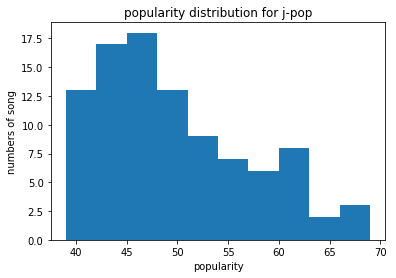

('mean of popularity ', 49.291666666666664)
('min of popularity ', 39.0)
('max of popularity ', 69.0)
('standard deviation of popularity ', 7.346917243474037)
('skewness of popularity ', 0.6929780661163695)
('kurtosis of popularity ', -0.4024851529691178)


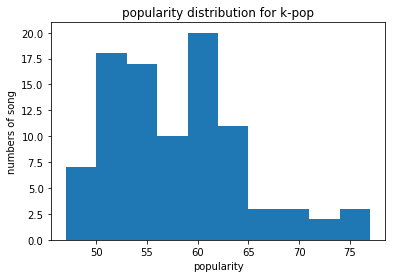

('mean of popularity ', 57.54255319148936)
('min of popularity ', 47.0)
('max of popularity ', 77.0)
('standard deviation of popularity ', 6.559348403281751)
('skewness of popularity ', 0.7978654828632658)
('kurtosis of popularity ', 0.423048458697024)


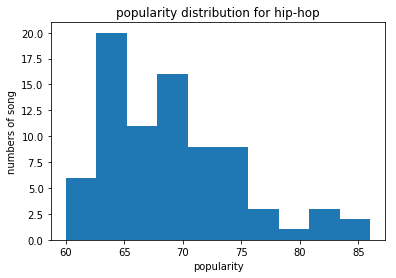

('mean of popularity ', 68.9125)
('min of popularity ', 60.0)
('max of popularity ', 86.0)
('standard deviation of popularity ', 5.774658190333854)
('skewness of popularity ', 0.8799568929287541)
('kurtosis of popularity ', 0.45772898318637845)


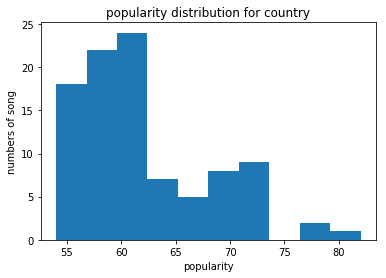

('mean of popularity ', 61.989583333333336)
('min of popularity ', 54.0)
('max of popularity ', 82.0)
('standard deviation of popularity ', 6.072361530854658)
('skewness of popularity ', 0.9170206175208505)
('kurtosis of popularity ', 0.34562439793597965)


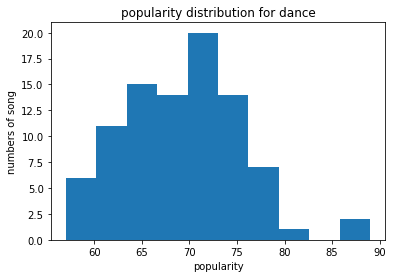

('mean of popularity ', 69.23333333333333)
('min of popularity ', 57.0)
('max of popularity ', 89.0)
('standard deviation of popularity ', 6.14625125538991)
('skewness of popularity ', 0.5013524717490567)
('kurtosis of popularity ', 0.6098109940109495)


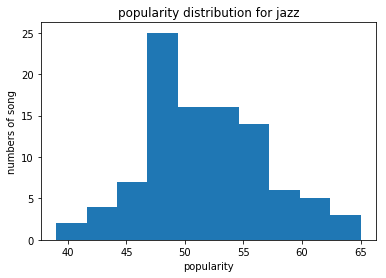

('mean of popularity ', 51.45918367346939)
('min of popularity ', 39.0)
('max of popularity ', 65.0)
('standard deviation of popularity ', 5.133613440414755)
('skewness of popularity ', 0.25965050179938787)
('kurtosis of popularity ', 0.0816017783148899)


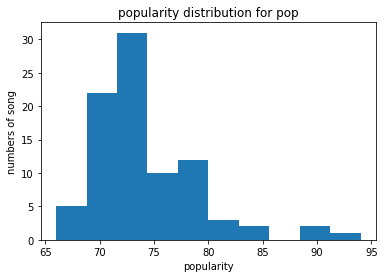

('mean of popularity ', 74.19318181818181)
('min of popularity ', 66.0)
('max of popularity ', 94.0)
('standard deviation of popularity ', 5.014594686972034)
('skewness of popularity ', 1.3484128528030743)
('kurtosis of popularity ', 2.8739840419693037)


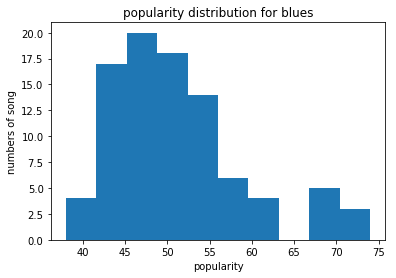

('mean of popularity ', 51.34065934065934)
('min of popularity ', 38.0)
('max of popularity ', 74.0)
('standard deviation of popularity ', 7.820514021497537)
('skewness of popularity ', 1.0877268284029413)
('kurtosis of popularity ', 0.9821078346370067)


In [7]:
data_collect = pd.DataFrame(columns=df.columns) 

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
        
    #作圖，繪出popularity散佈圖
    plt.hist(data_cato['popularity'],bins = 10) 
    plt.xlabel("popularity")
    plt.ylabel("numbers of song")
    title = "popularity distribution for "+cato[i]
    plt.title(title)
    plt.show()
    
    mean = data_cato['popularity'].mean()
    minimum = min(data_cato['popularity'])
    maximum = max(data_cato['popularity'])
    kurtosis = stats.kurtosis(data_cato['popularity'].values)
    skewness = stats.skew(data_cato['popularity'].values)
    std = data_cato['popularity'].std()
    

    print("mean of popularity ",mean)
    print("min of popularity ",minimum)
    print("max of popularity ",maximum)
    print("standard deviation of popularity ",std)
    print("skewness of popularity ",skewness)
    print("kurtosis of popularity ",kurtosis)
    
    data_collect = pd.concat([data_collect,data_cato])
    
# 看每種歌曲的popularity相關資料
summary = data_collect[['popularity','genre']].groupby('genre').describe()

In [8]:
summary

popularity                                                    
             count       mean       std   min    25%   50%   75%   max
genre                                                                 
blues         91.0  51.340659  7.820514  38.0  46.00  50.0  55.0  74.0
country       96.0  61.989583  6.072362  54.0  58.00  61.0  66.0  82.0
dance         90.0  69.233333  6.146251  57.0  65.00  69.0  73.0  89.0
hip-hop       80.0  68.912500  5.774658  60.0  64.75  68.0  72.0  86.0
j-pop         96.0  49.291667  7.346917  39.0  44.00  47.5  55.0  69.0
jazz          98.0  51.459184  5.133613  39.0  48.00  51.0  55.0  65.0
k-pop         94.0  57.542553  6.559348  47.0  52.00  57.0  61.0  77.0
pop           88.0  74.193182  5.014595  66.0  71.00  73.0  77.0  94.0

### 2.1 觀察每個歌曲類型的熱門程度平均數

In [9]:
data_mean = summary.iloc[:,1] #取mean欄位
data_mean = data_mean.sort_values() #由小到大排序
print(data_mean)

genre
j-pop      49.291667
blues      51.340659
jazz       51.459184
k-pop      57.542553
country    61.989583
hip-hop    68.912500
dance      69.233333
pop        74.193182
Name: (popularity, mean), dtype: float64


我們發現pop的平均熱門程度最高，j-pop最低。這個結果顯示各分類的熱門程度的平均數有明顯的差異，而不同分類的歌曲在各項特性會有差異，這讓我們好奇不同的特性會對歌曲的熱門程度造成什麼影響

### 2.2 觀察每個歌曲類型的熱門程度標準差

In [10]:
data_std = summary.iloc[:,2] #取std欄位
data_std = data_std.sort_values() #由小到大排序
print(data_std)

genre
pop        5.014595
jazz       5.133613
hip-hop    5.774658
country    6.072362
dance      6.146251
k-pop      6.559348
j-pop      7.346917
blues      7.820514
Name: (popularity, std), dtype: float64


我們發現pop的標準差最低，blues最高，這邊有一個十分有趣的現象，先前mean較高的歌曲類型通常會有較低的標準差

### 2.3 skewness and kurtosis

我們發現大部分的歌曲類型的熱門程度分佈都具備right-skewed的性質，而在kurtosis方面，只有pop超過1和blues接近1，顯示他們的分佈較為集中

### 2.4 檢查Outliers

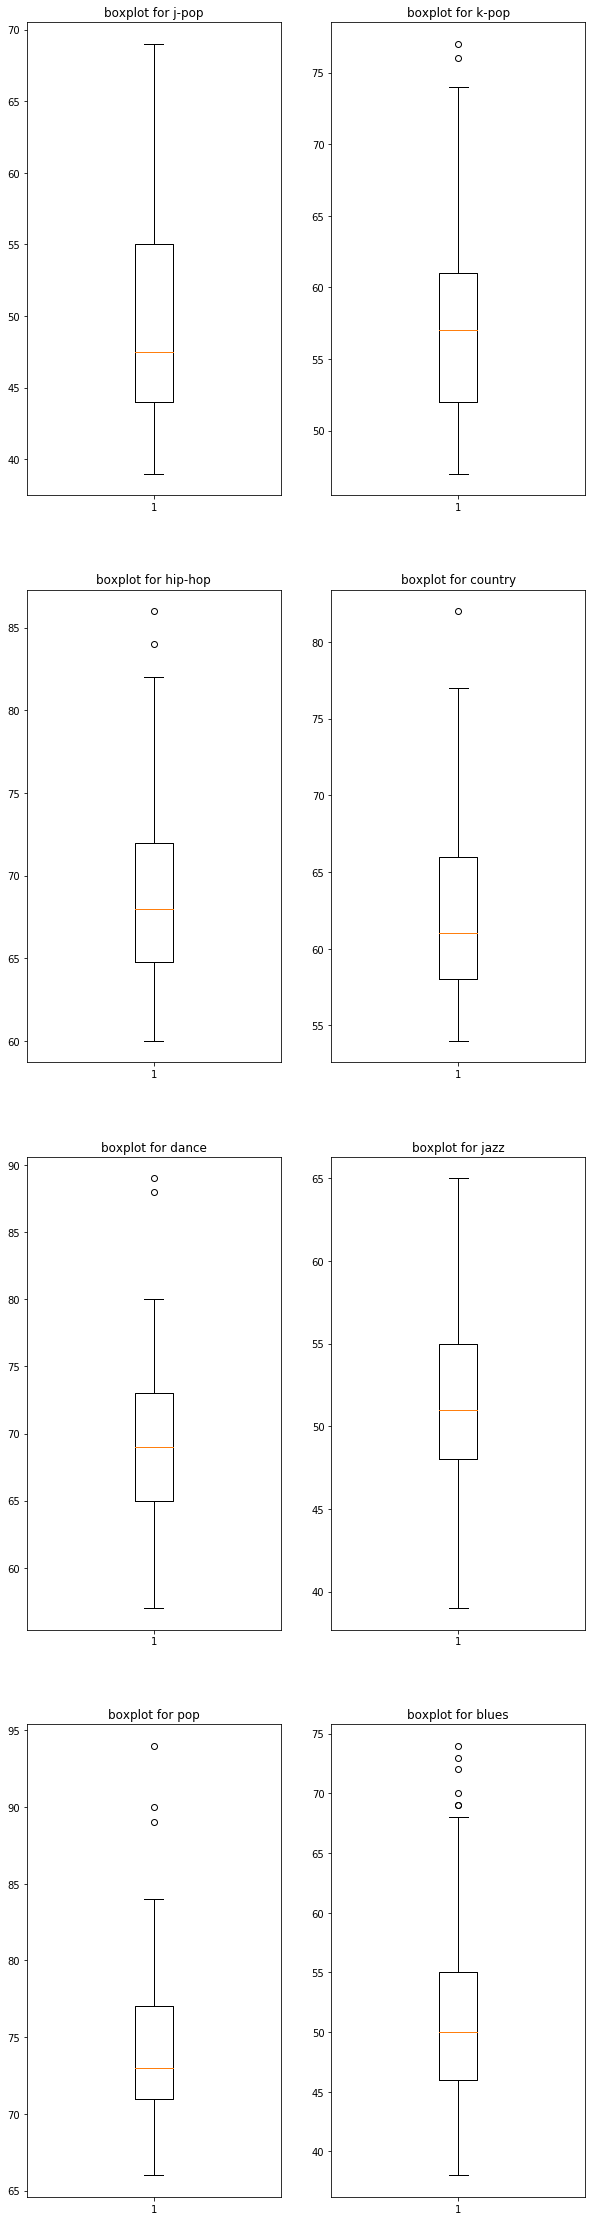

In [12]:
fig, axs = plt.subplots(int(len(cato)/2), 2, figsize=(10,40))

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
    
    #作圖，繪出popularity盒狀圖
    #data_cato['popularity'].plot(kind="box")
    axs[int(i/2), i%2].boxplot(data_cato['popularity'])
    title = "boxplot for "+cato[i]
    axs[int(i/2), i%2].set_title(title)

plt.show()

從各個歌曲分類的boxplot來看，outliers並不多

**<font face="微軟正黑體">假設檢定</font>**
---

**<font face="微軟正黑體">迴歸分析</font>**
---

**<font face="微軟正黑體">結論與建議</font>**
---